# 1D CNN-Attention AutoEncoder - Prokaryotic Domain

## Imports

In [9]:
import matplotlib.pyplot as plt
import time
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import math
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import transforms
from tqdm.notebook import tqdm

!pip install blosc
import blosc
import zstandard as zstd

import warnings

warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message=".*torch.cuda.amp.autocast.*"
)



#------- Parameters ----------

k = 1280
P = 4 #latent_size
batch_size = 128
chunk_size = k

In [2]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
random.seed(0)

## Training Function

In [3]:
def train(model,
          train_loader,
          test_loader,
          training_iterations,
          evaluation_iterations,
          verbose=False,
          device=None):

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    model = model.to(device)
    model.train()

    optimizer = optim.NAdam(model.parameters(), lr=0.0005)

    scaler = torch.cuda.amp.GradScaler()

    train_loss_vals = []
    eval_loss_vals = []

    train_losses = []
    eval_losses = []

    train_accuracies = []
    eval_accuracies = []

    pbar = tqdm(range(training_iterations))
    step_counter = 0

    while step_counter < training_iterations:
        for images, labels in train_loader:
            images = images.to(device)

        
            with torch.cuda.amp.autocast(dtype=torch.float16):
                encoded, reconstruction = model(images)
                mse_loss = torch.mean((images - reconstruction) ** 2)

            train_loss_vals.append(mse_loss.item())

            optimizer.zero_grad()

      
            scaler.scale(mse_loss).backward()
            scaler.step(optimizer)
            scaler.update()

            
            if step_counter % evaluation_iterations == 0:
                model.eval()
                eval_loss_batch = []

                with torch.no_grad():
                    for images, labels in test_loader:
                        images = images.to(device)

                        with torch.cuda.amp.autocast(dtype=torch.float16):
                            _, reconstruction = model(images)
                            loss_eval = torch.mean((images - reconstruction) ** 2)

                        eval_loss_batch.append(loss_eval.item())

                
                mean_train_loss = np.mean(train_loss_vals)
                mean_eval_loss = np.mean(eval_loss_batch)

                train_losses.append(mean_train_loss)
                eval_losses.append(mean_eval_loss)

                
                train_acc_batch = []
                with torch.no_grad():
                    for images, labels in train_loader:
                        images = images.to(device)

                        with torch.cuda.amp.autocast(dtype=torch.float16):
                            _, reconstruction = model(images)

                       
                        recon = reconstruction.float()
                        imgs = images.float()

                        pred = torch.clamp(torch.round(recon * 4.0), 0, 4).long()
                        true = torch.clamp(torch.round(imgs * 4.0), 0, 4).long()

                        train_acc_batch.append((pred == true).float().mean().item())

                train_acc = np.mean(train_acc_batch) * 100

                eval_acc_batch = []
                with torch.no_grad():
                    for images, labels in test_loader:
                        images = images.to(device)

                        with torch.cuda.amp.autocast(dtype=torch.float16):
                            _, reconstruction = model(images)

                        recon = reconstruction.float()
                        imgs = images.float()

                        pred = torch.clamp(torch.round(recon * 4.0), 0, 4).long()
                        true = torch.clamp(torch.round(imgs * 4.0), 0, 4).long()

                        eval_acc_batch.append((pred == true).float().mean().item())

                eval_acc = np.mean(eval_acc_batch) * 100

                train_accuracies.append(train_acc)
                eval_accuracies.append(eval_acc)

                if verbose:
                    tqdm.write(
                        f"Step {step_counter}: "
                        f"Train Loss = {mean_train_loss:.6f}, "
                        f"Eval Loss = {mean_eval_loss:.6f}, "
                        f"Train Accuracy = {train_acc:.2f}%, "
                        f"Eval Accuracy = {eval_acc:.2f}%"
                    )

                train_loss_vals = []
                eval_loss_vals = []
                model.train()

            step_counter += 1
            pbar.update(1)

            if step_counter >= training_iterations:
                print("Completed Training:")
                break

    print(f"\nFinal Training Loss: {train_losses[-1]:.6f}")
    print(f"Final Evaluation Loss: {eval_losses[-1]:.6f}")
    print(f"Final Training Accuracy: {train_accuracies[-1]:.6f}%")
    print(f"Final Evaluation Accuracy: {eval_accuracies[-1]:.6f}%")

    return model, train_losses, eval_losses, train_accuracies, eval_accuracies

## Architecture

In [4]:
# Self-Attention Block 
class _SelfAttnBlock1D(nn.Module):
    def __init__(self, in_channels: int, embed_dim: int,
                 num_heads: int = 4, dropout: float = 0.1):
        super().__init__()
        assert embed_dim % num_heads == 0

        self.proj_in = nn.Conv1d(in_channels, embed_dim, kernel_size=1)

        self.attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True,
            dropout=dropout
        )

        self.ln1 = nn.LayerNorm(embed_dim)

        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.GELU(),
            nn.Linear(4 * embed_dim, embed_dim),
        )

        self.ln2 = nn.LayerNorm(embed_dim)

    @staticmethod
    def _pos_enc(L, C, device, dtype):
        pe = torch.zeros(L, C, device=device, dtype=dtype)
        pos = torch.arange(0, L, device=device, dtype=dtype).unsqueeze(1)
        div = torch.exp(torch.arange(0, C, 2, device=device, dtype=dtype)
                        * (-math.log(10000.0) / C))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        return pe.unsqueeze(0)

    def forward(self, x):
        B, C, L = x.shape
        h = self.proj_in(x)            
        h = h.permute(0, 2, 1)        
        pe = self._pos_enc(L, h.size(-1), x.device, h.dtype)
        h = h + pe

        attn_out, _ = self.attn(h, h, h, need_weights=False)
        h = self.ln1(h + attn_out)

        ffn_out = self.ffn(h)
        h = self.ln2(h + ffn_out)

        return h.permute(0, 2, 1)     


# Decoder with Self-Attention 
class _DecoderWithSelfAttention(nn.Module):
    def __init__(self, latent_dim, embed_dim=32, num_heads=4):
        super().__init__()

        # L/16 -> L/8
        self.up1 = nn.ConvTranspose1d(latent_dim, 128, 3, 2, 1, 1)
        self.bn1 = nn.BatchNorm1d(128)
        self.attn1 = _SelfAttnBlock1D(128, 128, num_heads)

        # L/8 -> L/4
        self.up2 = nn.ConvTranspose1d(128, 64, 3, 2, 1, 1)
        self.bn2 = nn.BatchNorm1d(64)
        self.attn2 = _SelfAttnBlock1D(64, 64, num_heads)

        # L/4 -> L/2
        self.up3 = nn.ConvTranspose1d(64, embed_dim, 3, 2, 1, 1)
        self.bn3 = nn.BatchNorm1d(embed_dim)
        self.attn3 = _SelfAttnBlock1D(embed_dim, embed_dim, num_heads)

        # L/2 -> L
        self.up_final = nn.ConvTranspose1d(embed_dim, 1, 3, 2, 1, 1)

    def forward(self, z):
        x = F.relu(self.bn1(self.up1(z)))
        x = self.attn1(x)

        x = F.relu(self.bn2(self.up2(x)))
        x = self.attn2(x)

        x = F.relu(self.bn3(self.up3(x)))
        x = self.attn3(x)

        return torch.sigmoid(self.up_final(x))



# Full Autoencoder 
class ConvolutionalAutoEncoder1D(nn.Module):
    def __init__(self, in_channels=1, latent_dim=4,
                 attn_embed_dim=32, attn_heads=4):
        super().__init__()

        self.latent_dim = latent_dim

        self.encoder_stem = nn.Sequential(
            nn.Conv1d(in_channels, 32, 3, 2, 1),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.Conv1d(32, 64, 3, 2, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Conv1d(64, 128, 3, 2, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            
            nn.Conv1d(128, 128, 3, 2, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )

        
        self.encoder_attn = _SelfAttnBlock1D(
            in_channels=128,
            embed_dim=128,
            num_heads=attn_heads
        )

    
        self.channel_funnel = nn.Sequential(
            nn.Conv1d(128, 64, kernel_size=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Conv1d(64, 32, kernel_size=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.Conv1d(32, latent_dim, kernel_size=1),
        )

        
        self.latent_to_decoder = nn.Conv1d(
            latent_dim, attn_embed_dim, kernel_size=1
        )

        self.decoder = _DecoderWithSelfAttention(
            latent_dim=attn_embed_dim,
            embed_dim=attn_embed_dim,
            num_heads=attn_heads
        )

    def forward_enc(self, x):
        h = self.encoder_stem(x)     
        h = self.encoder_attn(h)     
        z = self.channel_funnel(h) 
        return z

    def forward_dec(self, z):
        z = self.latent_to_decoder(z)
        return self.decoder(z)

    def forward(self, x):
        z = self.forward_enc(x)
        y = self.forward_dec(z)
        return z.to(torch.float16), y.to(torch.float16)

## Instantiation

In [5]:
conv1d_model = ConvolutionalAutoEncoder1D(in_channels=1, latent_dim=P,
                                          attn_embed_dim=32, attn_heads=4)

## Dataloaders and Model Training


=== Training on AeCa ===


/tmp/ipykernel_47/3030974146.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


  0%|          | 0/20000 [00:00<?, ?it/s]

Step 0: Train Loss = 0.224357, Eval Loss = 0.219464, Train Accuracy = 19.14%, Eval Accuracy = 19.23%
Step 200: Train Loss = 0.063539, Eval Loss = 0.048808, Train Accuracy = 40.79%, Eval Accuracy = 40.83%
Step 400: Train Loss = 0.043658, Eval Loss = 0.038579, Train Accuracy = 46.31%, Eval Accuracy = 46.13%
Step 600: Train Loss = 0.031837, Eval Loss = 0.026333, Train Accuracy = 53.11%, Eval Accuracy = 52.85%
Step 800: Train Loss = 0.024246, Eval Loss = 0.024458, Train Accuracy = 54.55%, Eval Accuracy = 54.23%
Step 1000: Train Loss = 0.021021, Eval Loss = 0.020891, Train Accuracy = 54.95%, Eval Accuracy = 54.65%
Step 1200: Train Loss = 0.017597, Eval Loss = 0.016581, Train Accuracy = 60.43%, Eval Accuracy = 59.73%
Step 1400: Train Loss = 0.015830, Eval Loss = 0.015900, Train Accuracy = 61.63%, Eval Accuracy = 60.87%
Step 1600: Train Loss = 0.015130, Eval Loss = 0.016271, Train Accuracy = 60.91%, Eval Accuracy = 60.24%
Step 1800: Train Loss = 0.014728, Eval Loss = 0.014963, Train Accuracy 

  0%|          | 0/20000 [00:00<?, ?it/s]

Step 0: Train Loss = 0.029638, Eval Loss = 0.028070, Train Accuracy = 55.98%, Eval Accuracy = 56.00%
Step 200: Train Loss = 0.011229, Eval Loss = 0.010214, Train Accuracy = 75.64%, Eval Accuracy = 75.41%
Step 400: Train Loss = 0.010100, Eval Loss = 0.010093, Train Accuracy = 75.77%, Eval Accuracy = 75.52%
Step 600: Train Loss = 0.009863, Eval Loss = 0.010080, Train Accuracy = 75.56%, Eval Accuracy = 75.19%
Step 800: Train Loss = 0.009637, Eval Loss = 0.009904, Train Accuracy = 76.44%, Eval Accuracy = 76.04%
Step 1000: Train Loss = 0.009384, Eval Loss = 0.010178, Train Accuracy = 76.02%, Eval Accuracy = 75.63%
Step 1200: Train Loss = 0.009247, Eval Loss = 0.009037, Train Accuracy = 79.08%, Eval Accuracy = 78.58%
Step 1400: Train Loss = 0.009077, Eval Loss = 0.008548, Train Accuracy = 80.50%, Eval Accuracy = 79.93%
Step 1600: Train Loss = 0.008947, Eval Loss = 0.008216, Train Accuracy = 81.57%, Eval Accuracy = 80.98%
Step 1800: Train Loss = 0.008797, Eval Loss = 0.010274, Train Accuracy 

  0%|          | 0/20000 [00:00<?, ?it/s]

Step 0: Train Loss = 0.057247, Eval Loss = 0.022098, Train Accuracy = 61.55%, Eval Accuracy = 61.58%
Step 200: Train Loss = 0.016974, Eval Loss = 0.013470, Train Accuracy = 70.90%, Eval Accuracy = 70.75%
Step 400: Train Loss = 0.013069, Eval Loss = 0.012126, Train Accuracy = 73.55%, Eval Accuracy = 73.27%
Step 600: Train Loss = 0.012313, Eval Loss = 0.011228, Train Accuracy = 75.30%, Eval Accuracy = 74.98%
Step 800: Train Loss = 0.011796, Eval Loss = 0.011419, Train Accuracy = 75.01%, Eval Accuracy = 74.66%
Step 1000: Train Loss = 0.011504, Eval Loss = 0.010890, Train Accuracy = 75.78%, Eval Accuracy = 75.46%
Step 1200: Train Loss = 0.011027, Eval Loss = 0.011221, Train Accuracy = 75.19%, Eval Accuracy = 74.87%
Step 1400: Train Loss = 0.010746, Eval Loss = 0.010141, Train Accuracy = 77.75%, Eval Accuracy = 77.43%
Step 1600: Train Loss = 0.010536, Eval Loss = 0.010998, Train Accuracy = 75.87%, Eval Accuracy = 75.43%
Step 1800: Train Loss = 0.010367, Eval Loss = 0.009849, Train Accuracy 

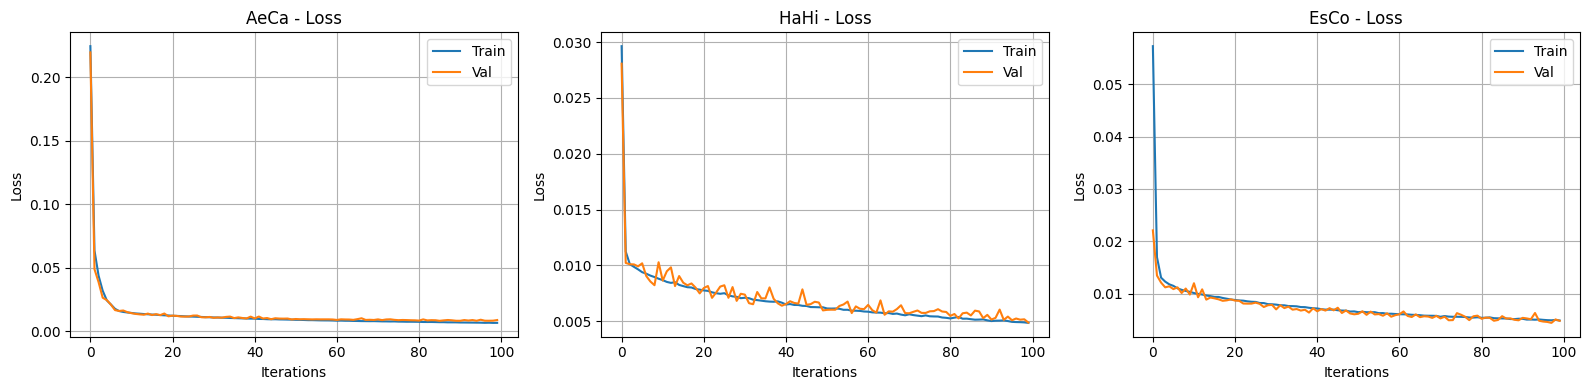

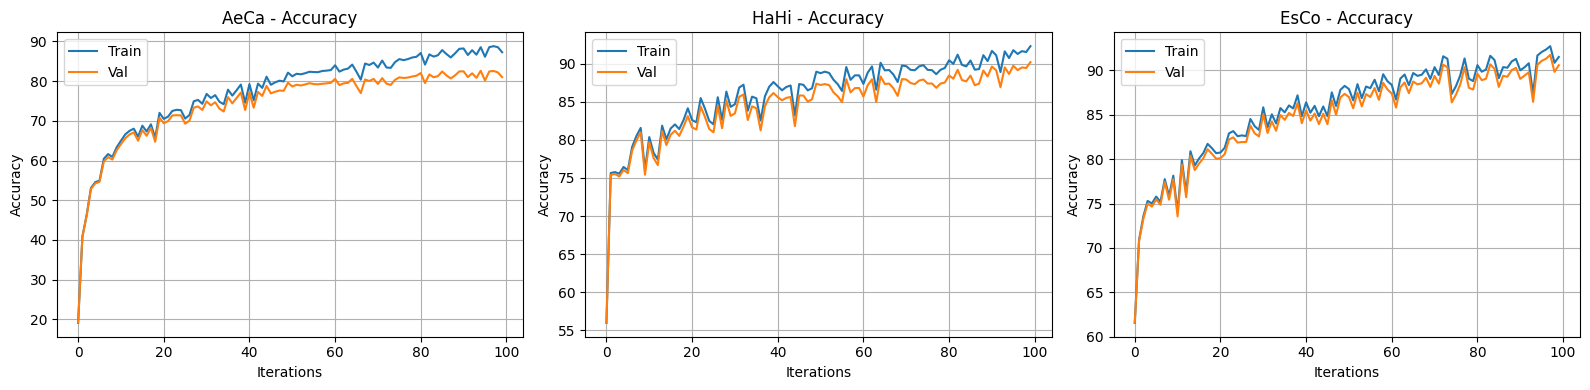

In [6]:
history_per_file = {}
file_times = {}

files_to_load = ['AeCa', 'HaHi', 'EsCo']
data_dir = "/kaggle/input/dnacorpus/DNACorpus/Prokaryotic"

for fname in files_to_load:
    print(f"\n=== Training on {fname} ===")
    
    start_time = time.time()   

    with open(os.path.join(data_dir, fname), 'r') as f:
        seq = f.read().strip()

    content = seq.translate(str.maketrans('ATCG', '0123'))

    remainder = len(content) % chunk_size
    if remainder != 0:
        pad_len = chunk_size - remainder
        content = content.ljust(len(content) + pad_len, '4')
    
    content_array = np.frombuffer(content.encode('ascii'), dtype=np.uint8) - ord('0')
    content_array = content_array.astype(np.float16) / 4.0

    reshaped = content_array.reshape(-1, chunk_size)
    tensor_data = torch.tensor(reshaped, dtype=torch.float16).unsqueeze(1)

    dummy_labels = torch.zeros(len(tensor_data), dtype=torch.uint8)

    full_dataset = TensorDataset(tensor_data, dummy_labels)
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    #Train model
    conv1d_model, train_losses, eval_losses, train_accs, eval_accs = train(
        conv1d_model,
        train_loader,
        test_loader,
        training_iterations=20000,
        evaluation_iterations=200,
        verbose=True
    )

    end_time = time.time()
    file_times[fname] = end_time - start_time
    history_per_file[fname] = {
    "train_loss": train_losses,
    "val_loss": eval_losses,
    "train_acc": train_accs,
    "val_acc": eval_accs
    }

print("\n\n PER-FILE TRAINING TIME ")

for fname in files_to_load:
    print(f"\nFile: {fname}")
    print(f"  Training Time: {file_times[fname]:.2f} seconds")

print("\n LOSS AND ACCURACY ")

plt.figure(figsize=(16, 4))

for i, fname in enumerate(files_to_load):
    hist = history_per_file[fname]
    plt.subplot(1, len(files_to_load), i + 1)
    plt.plot(hist["train_loss"], label="Train")
    plt.plot(hist["val_loss"], label="Val")
    plt.title(f"{fname} - Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


plt.figure(figsize=(16, 4))

for i, fname in enumerate(files_to_load):
    hist = history_per_file[fname]
    plt.subplot(1, len(files_to_load), i + 1)
    plt.plot(hist["train_acc"], label="Train")
    plt.plot(hist["val_acc"], label="Val")
    plt.title(f"{fname} - Accuracy")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

## Saving Model Weights

In [7]:
# Save model weights 
torch.save(conv1d_model.state_dict(), "/kaggle/working/autoencoder.pth")

## Model Testing


Processing: AeCa | Length: 1591049


  → Encoding & Decoding AeCa:   0%|          | 0/1244 [00:00<?, ?it/s]


Processing: AgPh | Length: 43970


  → Encoding & Decoding AgPh:   0%|          | 0/35 [00:00<?, ?it/s]


Processing: BuEb | Length: 18940


  → Encoding & Decoding BuEb:   0%|          | 0/15 [00:00<?, ?it/s]


Processing: EsCo | Length: 4641652


  → Encoding & Decoding EsCo:   0%|          | 0/3627 [00:00<?, ?it/s]


Processing: HaHi | Length: 3890005


  → Encoding & Decoding HaHi:   0%|          | 0/3040 [00:00<?, ?it/s]


Processing: HePy | Length: 1667825


  → Encoding & Decoding HePy:   0%|          | 0/1303 [00:00<?, ?it/s]


Processing: YeMi | Length: 73689


  → Encoding & Decoding YeMi:   0%|          | 0/58 [00:00<?, ?it/s]


Saved evaluation_results.csv (TRAIN files only)
file  original_len  latent_size  accuracy (%)  compress_ratio
AeCa       1591049       796160         87.31             0.5
EsCo       4641652      2321280         91.37             0.5
HaHi       3890005      1945600         90.19             0.5

Saved evaluation_results_test.csv (TEST files only)
file  original_len  latent_size  accuracy (%)  compress_ratio
AgPh         43970        22400         89.59            0.51
BuEb         18940         9600         88.03            0.51
HePy       1667825       833920         89.12            0.50
YeMi         73689        37120         88.63            0.50


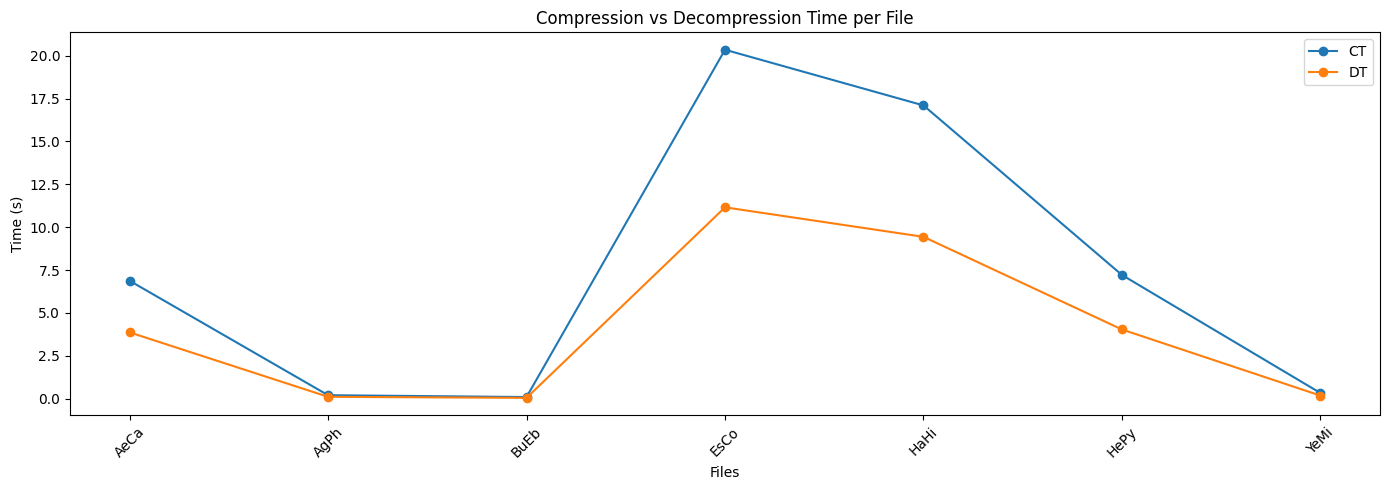

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ConvolutionalAutoEncoder1D(in_channels=1, latent_dim=P)
model.load_state_dict(torch.load("/kaggle/working/autoencoder.pth", map_location=device))
# to load already trained model
# model.load_state_dict(torch.load("/kaggle/input/fp16-improved-prokar-p4-20k/pytorch/default/1/FP16_Improved_Prokar_P4_20K.pth", map_location=device))
model.to(device)
model.eval()
model.half()

latent_dir = "/kaggle/working/latent"
os.makedirs(latent_dir, exist_ok=True)  

chunk_length = k
corpus_dir = "/kaggle/input/dnacorpus/DNACorpus/Prokaryotic"
vocab = ['A', 'T', 'C', 'G', 'N']

comp_times = []
decomp_times = []
file_labels = []

def preprocess_sequence_1d(seq, chunk_length=k):
    seq = seq.translate(str.maketrans("ATCG", "0123"))
    remainder = len(seq) % chunk_length
    if remainder != 0:
        pad_len = chunk_length - remainder
        seq = seq.ljust(len(seq) + pad_len, '4')
    arr = np.frombuffer(seq.encode('ascii'), dtype=np.uint8) - ord("0")
    arr = arr / 4.0 
    arr = np.reshape(arr, (-1, chunk_length))
    return torch.tensor(arr, dtype=torch.float16).unsqueeze(1)  

def decode_tensor_to_seq_1d(tensor, vocab):
    arr = tensor.squeeze().cpu().numpy()
    arr = np.clip(arr, 0, 1)
    indices = np.rint(arr * (len(vocab) - 1)).astype(int)
    indices = np.clip(indices, 0, len(vocab) - 1)
    return ''.join([vocab[i] for i in indices.flatten()])

def compute_accuracy(seq1, seq2):
    matches = sum(a == b for a, b in zip(seq1, seq2))
    return matches / len(seq1) * 100

# train_files 
train_files = ['AeCa', 'HaHi', 'EsCo']

test_files = [f for f in os.listdir(corpus_dir) if f not in train_files]

results = []

for filename in sorted(os.listdir(corpus_dir)):
    filepath = os.path.join(corpus_dir, filename)
    if not os.path.isfile(filepath):
        continue

    with open(filepath, 'r') as f:
        raw_seq = f.read().strip().upper()

    print(f"\nProcessing: {filename} | Length: {len(raw_seq)}")
    input_tensor = preprocess_sequence_1d(raw_seq, chunk_length).to(device)

    recon_seq = ""
    latent_total = 0
    n_chunks = len(input_tensor)

    with torch.no_grad():
        first_chunk = model.forward_enc(input_tensor[0].unsqueeze(0))
        latent_shape = first_chunk.shape[1:]
        latent_dtype = np.float16

        mmap_path = os.path.join(latent_dir, f"{filename}.dat")
        latent_mmap = np.memmap(mmap_path, dtype=latent_dtype, mode='w+', shape=(n_chunks, *latent_shape))

        comp_start = time.time()
        decomp_time_accum = 0.0

        for i in tqdm(range(n_chunks), desc=f"  → Encoding & Decoding {filename}"):
            chunk = input_tensor[i].unsqueeze(0)
    
            
            t1 = time.time()
            encoded = model.forward_enc(chunk)
            t2 = time.time()
            comp_time_step = (t2 - t1)

            
            t3 = time.time()
            decoded = model.forward_dec(encoded)
            t4 = time.time()
            decomp_time_step = (t4 - t3)

            decomp_time_accum += decomp_time_step

            latent_np = encoded.cpu().numpy().astype(latent_dtype)[0]
            latent_mmap[i] = latent_np

            latent_total += encoded.numel()
            recon_seq += decode_tensor_to_seq_1d(decoded, vocab)

      

        latent_mmap.flush()
        final_latent = np.memmap(mmap_path, dtype=latent_dtype, mode='r', shape=(n_chunks, *latent_shape))
        np.save(os.path.join(latent_dir, f"{filename}.npy"), np.array(final_latent))
        os.remove(mmap_path)

    recon_seq = recon_seq[:len(raw_seq)]
    accuracy = compute_accuracy(raw_seq, recon_seq)

    comp_end = time.time()

    comp_times.append(comp_end - comp_start)
    decomp_times.append(decomp_time_accum)
    file_labels.append(filename)


    results.append({
        "file": filename,
        "original_len": len(raw_seq),
        "latent_size": latent_total * 2,
        "accuracy (%)": round(accuracy, 2),
        "compress_ratio": round(latent_total * 2 / len(raw_seq), 2)
    })


df = pd.DataFrame(results)

df_train = df[df["file"].isin(train_files)]
df_train.to_csv("/kaggle/working/evaluation_results.csv", index=False)
print("\nSaved evaluation_results.csv (TRAIN files only)")
print(df_train.to_string(index=False))


df_test = df[df["file"].isin(test_files)]
df_test.to_csv("/kaggle/working/evaluation_results_test.csv", index=False)
print("\nSaved evaluation_results_test.csv (TEST files only)")
print(df_test.to_string(index=False))

plt.figure(figsize=(14, 5))

plt.plot(file_labels, comp_times, marker='o', label="CT")
plt.plot(file_labels, decomp_times, marker='o', label="DT")

plt.xlabel("Files")
plt.ylabel("Time (s)")
plt.title("Compression vs Decompression Time per File")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Int8 Quantization 

In [11]:
quant_results = []

recon_int8_dir  = "/kaggle/working/recon_int8"
latent_int8_dir = "/kaggle/working/latent_int8"

os.makedirs(recon_int8_dir, exist_ok=True)
os.makedirs(latent_int8_dir, exist_ok=True)

def quantize_int8_symmetric_per_channel(latent_fp16):
    
    scale = np.max(np.abs(latent_fp16), axis=(0, 2), keepdims=True)
    scale[scale == 0] = 1.0  

    latent_int8 = np.round(latent_fp16 / scale * 127).astype(np.int8)
    return latent_int8, scale.astype(np.float16)


def dequantize_int8_symmetric_per_channel(latent_int8, scale):
   
    return latent_int8.astype(np.float16) * scale / 127



for _, row in df.iterrows():
    fname = row["file"]

    with open(os.path.join(corpus_dir, fname), "r") as f:
        raw_seq = f.read().strip().upper()

    latent_fp16 = np.load(os.path.join(latent_dir, f"{fname}.npy"))

    latent_int8, scale = quantize_int8_symmetric_per_channel(latent_fp16)

    np.save(os.path.join(latent_int8_dir, f"{fname}_latent_int8.npy"), latent_int8)
    np.save(os.path.join(latent_int8_dir, f"{fname}_scale.npy"), scale)

    latent_fp16_recon = dequantize_int8_symmetric_per_channel(latent_int8, scale)
    latent_tensor = torch.tensor(latent_fp16_recon,
                                 dtype=torch.float16,
                                 device=device)

    recon_seq = ""
    with torch.no_grad():
        for i in tqdm(range(latent_tensor.shape[0]),
                      desc=f"  → Decoding int8 {fname}"):
            decoded_chunk = model.forward_dec(latent_tensor[i:i+1])
            recon_seq += decode_tensor_to_seq_1d(decoded_chunk, vocab)

    recon_seq = recon_seq[:len(raw_seq)]

    if fname in train_files:
        subdir = os.path.join(recon_int8_dir, "train")
    else:
        subdir = os.path.join(recon_int8_dir, "test")

    os.makedirs(subdir, exist_ok=True)

    out_path = os.path.join(subdir, f"{fname}_recon_int8.txt")
    with open(out_path, "w") as f:
        f.write(recon_seq)

    accuracy = compute_accuracy(raw_seq, recon_seq)
    
    int8_size = latent_int8.nbytes + scale.nbytes
    int8_ratio = round(int8_size / len(raw_seq), 4)

    quant_results.append({
        "file": fname,
        "int8_size_bytes": int8_size,
        "int8_ratio": int8_ratio,
        "int8_acc (%)": round(accuracy, 2)
    })



quant_df = pd.DataFrame(quant_results)

df_train = pd.read_csv("/kaggle/working/evaluation_results.csv")
df_train = df_train.merge(quant_df, on="file", how="left")
df_train.to_csv("/kaggle/working/evaluation_results.csv", index=False)

df_test = pd.read_csv("/kaggle/working/evaluation_results_test.csv")
df_test = df_test.merge(quant_df, on="file", how="left")
df_test.to_csv("/kaggle/working/evaluation_results_test.csv", index=False)

print("\n int8 quantization results")
print(df_train.to_string(index=False))
print(df_test.to_string(index=False))

  → Decoding int8 AeCa:   0%|          | 0/1244 [00:00<?, ?it/s]

  → Decoding int8 AgPh:   0%|          | 0/35 [00:00<?, ?it/s]

  → Decoding int8 BuEb:   0%|          | 0/15 [00:00<?, ?it/s]

  → Decoding int8 EsCo:   0%|          | 0/3627 [00:00<?, ?it/s]

  → Decoding int8 HaHi:   0%|          | 0/3040 [00:00<?, ?it/s]

  → Decoding int8 HePy:   0%|          | 0/1303 [00:00<?, ?it/s]

  → Decoding int8 YeMi:   0%|          | 0/58 [00:00<?, ?it/s]


 int8 quantization results
file  original_len  latent_size  accuracy (%)  compress_ratio  int8_size_bytes  int8_ratio  int8_acc (%)
AeCa       1591049       796160         87.31             0.5           398088      0.2502         77.39
EsCo       4641652      2321280         91.37             0.5          1160648      0.2501         81.17
HaHi       3890005      1945600         90.19             0.5           972808      0.2501         79.22
file  original_len  latent_size  accuracy (%)  compress_ratio  int8_size_bytes  int8_ratio  int8_acc (%)
AgPh         43970        22400         89.59            0.51            11208      0.2549         83.32
BuEb         18940         9600         88.03            0.51             4808      0.2539         82.60
HePy       1667825       833920         89.12            0.50           416968      0.2500         80.99
YeMi         73689        37120         88.63            0.50            18568      0.2520         84.04


## Entropy Encoding (Zstd)

In [12]:
latent_int8_zstd_dir = "/kaggle/working/latent_int8_zstd"
os.makedirs(latent_int8_zstd_dir, exist_ok=True)

# ZSTD COMPRESSOR 
zstd_compressor = zstd.ZstdCompressor(level=22)

def compute_int8_blosc_stats(df_subset):
    int8_blosc_sizes = []
    int8_blosc_ratios = []

    for row in df_subset.itertuples(index=False):
        fname = row.file

        latent_fp32 = np.load(os.path.join(latent_dir, f"{fname}.npy"))

        min_val, max_val = latent_fp32.min(), latent_fp32.max()
        scale = (max_val - min_val) / 255 if max_val > min_val else 1.0
        latent_int8 = np.round((latent_fp32 - min_val) / scale).astype(np.uint8)

        compressed_bytes = zstd_compressor.compress(latent_int8.tobytes())
        compressed_size = len(compressed_bytes)

        out_path = os.path.join(latent_int8_zstd_dir, f"{fname}_latent_int8.zst")
        with open(out_path, "wb") as f:
            f.write(compressed_bytes)

        ratio = round(compressed_size / row.original_len, 4)

        int8_blosc_sizes.append(compressed_size)
        int8_blosc_ratios.append(ratio)

    df_subset["int8_blosc_size"] = int8_blosc_sizes
    df_subset["int8_blosc_ratio"] = int8_blosc_ratios

    return df_subset

df_train = pd.read_csv("/kaggle/working/evaluation_results.csv")
df_test = pd.read_csv("/kaggle/working/evaluation_results_test.csv")

df_train = compute_int8_blosc_stats(df_train)
df_test = compute_int8_blosc_stats(df_test)

df_train.to_csv("/kaggle/working/evaluation_results.csv", index=False)
df_test.to_csv("/kaggle/working/evaluation_results_test.csv", index=False)

print("\nAdded int8 Blosc stats to both CSVs")
print("\n--- TRAIN ---")
print(df_train.to_string(index=False))
print("\n--- TEST ---")
print(df_test.to_string(index=False))



Added int8 Blosc stats to both CSVs

--- TRAIN ---
file  original_len  latent_size  accuracy (%)  compress_ratio  int8_size_bytes  int8_ratio  int8_acc (%)  int8_blosc_size  int8_blosc_ratio
AeCa       1591049       796160         87.31             0.5           398088      0.2502         77.39           332148            0.2088
EsCo       4641652      2321280         91.37             0.5          1160648      0.2501         81.17           965301            0.2080
HaHi       3890005      1945600         90.19             0.5           972808      0.2501         79.22           802036            0.2062

--- TEST ---
file  original_len  latent_size  accuracy (%)  compress_ratio  int8_size_bytes  int8_ratio  int8_acc (%)  int8_blosc_size  int8_blosc_ratio
AgPh         43970        22400         89.59            0.51            11208      0.2549         83.32             9594            0.2182
BuEb         18940         9600         88.03            0.51             4808      0.2539    

## Compute Residual (Predictive Format)

In [13]:
import os
import numpy as np
import zstandard as zstd
import struct

orig_dir = "/kaggle/input/dnacorpus/DNACorpus/Prokaryotic"
recon_root = "/kaggle/working/recon_int8"
res_root = "/kaggle/working/RESIDUALS"

subfolders = ["train", "test"]

for sf in subfolders:
    os.makedirs(os.path.join(res_root, sf), exist_ok=True)

BASE2INT = {'A':0, 'T':1, 'C':2, 'G':3, 'N':3}

zstd_compressor = zstd.ZstdCompressor(level=22)

def pack_2bit(arr):
    n = len(arr)
    out = bytearray((n + 3) // 4)
    for i, v in enumerate(arr):
        out[i // 4] |= (v & 3) << (6 - 2 * (i % 4))
    return bytes(out)

for split in subfolders:
    recon_dir = os.path.join(recon_root, split)
    res_out_dir = os.path.join(res_root, split)

    files = sorted(os.listdir(recon_dir))

    print(f"\n Processing {split.upper()} ({len(files)} files) ")

    for fname in files:

        if not fname.endswith("_recon_int8.txt"):
            continue

        base = fname.replace("_recon_int8.txt", "")
        orig_path = os.path.join(orig_dir, base)
        recon_path = os.path.join(recon_dir, fname)

        if not os.path.exists(orig_path):
            print(f"Skipping {fname}: original not found")
            continue

        
        with open(orig_path) as f:
            original = f.read().strip().upper()
        with open(recon_path) as f:
            reconstructed = f.read().strip().upper()

        L = min(len(original), len(reconstructed))
        original = original[:L]
        reconstructed = reconstructed[:L]

        
        orig_i  = np.fromiter((BASE2INT[b] for b in original), dtype=np.uint8)
        recon_i = np.fromiter((BASE2INT[b] for b in reconstructed), dtype=np.uint8)
        residual = (orig_i - recon_i) & 3

        packed = pack_2bit(residual)
        
        payload = struct.pack("<I", L) + packed

        compressed = zstd_compressor.compress(payload)

        out_path = os.path.join(res_out_dir, base + ".res.zst")
        with open(out_path, "wb") as f:
            f.write(compressed)

        print(
            f"Saved RES: {out_path} | "
            f"L={L} | "
            f"packed={len(packed)} | "
            f"zstd={len(compressed)} bytes"
        )

print("\n 2-bit packed predictive residuals generated successfully!")


 Processing TRAIN (3 files) 
Saved RES: /kaggle/working/RESIDUALS/train/AeCa.res.zst | L=1591049 | packed=397763 | zstd=204266 bytes
Saved RES: /kaggle/working/RESIDUALS/train/EsCo.res.zst | L=4641652 | packed=1160413 | zstd=525259 bytes
Saved RES: /kaggle/working/RESIDUALS/train/HaHi.res.zst | L=3890005 | packed=972502 | zstd=479538 bytes

 Processing TEST (4 files) 
Saved RES: /kaggle/working/RESIDUALS/test/AgPh.res.zst | L=43970 | packed=10993 | zstd=4547 bytes
Saved RES: /kaggle/working/RESIDUALS/test/BuEb.res.zst | L=18940 | packed=4735 | zstd=2041 bytes
Saved RES: /kaggle/working/RESIDUALS/test/HePy.res.zst | L=1667825 | packed=416957 | zstd=191889 bytes
Saved RES: /kaggle/working/RESIDUALS/test/YeMi.res.zst | L=73689 | packed=18423 | zstd=7363 bytes

 2-bit packed predictive residuals generated successfully!


## Final Compressed Size


 Overall compression ratios

--- TRAIN RESULTS PREVIEW ---
file  orig_size_bytes  latent_int8_bytes  residual_bytes  total_output_bytes  overall_compression_ratio
AeCa          1591049             332148          204266              536414                   0.337145
EsCo          4641652             965301          525259             1490560                   0.321127
HaHi          3890005             802036          479538             1281574                   0.329453

--- TEST RESULTS PREVIEW ---
file  orig_size_bytes  latent_int8_bytes  residual_bytes  total_output_bytes  overall_compression_ratio
AgPh            43970               9594            4547               14141                   0.321606
BuEb            18940               4349            2041                6390                   0.337381
HePy          1667825             347751          191889              539640                   0.323559
YeMi            73689              16336            7363               23699  

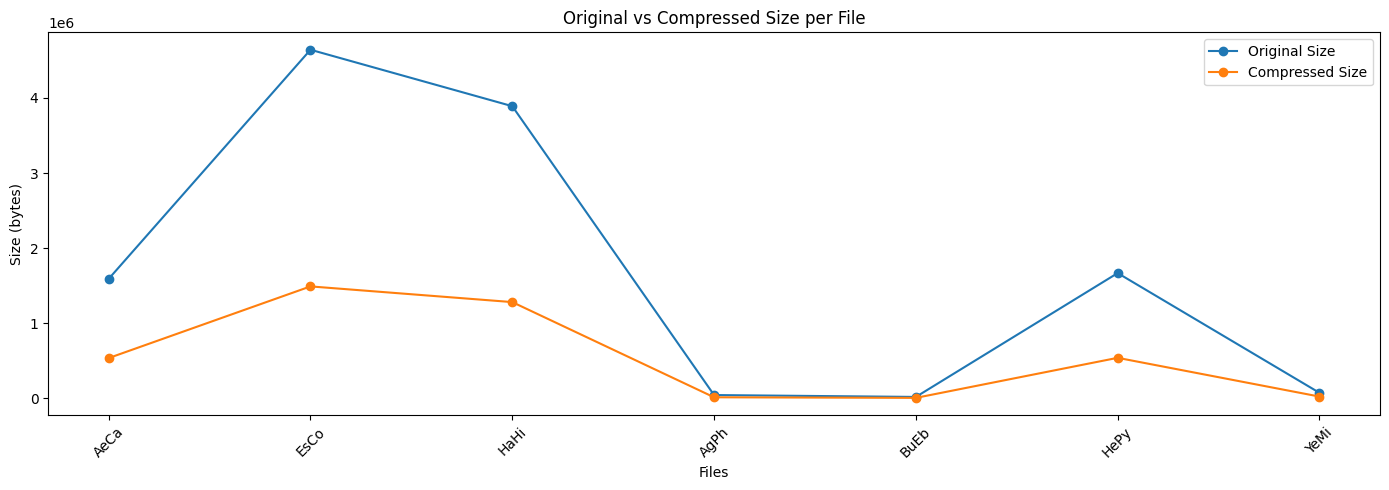

In [14]:
orig_dir        = "/kaggle/input/dnacorpus/DNACorpus/Prokaryotic"
latent_int8_dir = "/kaggle/working/latent_int8_zstd"
res_root        = "/kaggle/working/RESIDUALS"

train_csv = "/kaggle/working/evaluation_results.csv"
test_csv  = "/kaggle/working/evaluation_results_test.csv"

subfolders = ["train", "test"]

def get_file_size(path):
    return os.path.getsize(path) if os.path.exists(path) else 0


def compute_ratios(df, split):
    results = []
    res_dir = os.path.join(res_root, split)

    for _, row in df.iterrows():
        fname = row["file"]

        orig_path = os.path.join(orig_dir, fname)
        orig_size = get_file_size(orig_path)
        
        latent_path = os.path.join(latent_int8_dir, f"{fname}_latent_int8.zst")
        latent_size = get_file_size(latent_path)

        res_path = os.path.join(res_dir, f"{fname}.res.zst")
        residual_size = get_file_size(res_path)

        total_size = latent_size + residual_size

        comp_ratio = round(total_size / orig_size, 6) if orig_size > 0 else 0.0

        results.append({
            "file": fname,
            "orig_size_bytes": orig_size,
            "latent_int8_bytes": latent_size,
            "residual_bytes": residual_size,
            "total_output_bytes": total_size,
            "overall_compression_ratio": comp_ratio
        })

    return pd.DataFrame(results)


df_train = pd.read_csv(train_csv)
train_stats = compute_ratios(df_train, "train")

df_train["file"] = df_train["file"].astype(str).str.strip()
train_stats["file"] = train_stats["file"].astype(str).str.strip()

df_train = df_train.merge(train_stats, on="file", how="left")
df_train.to_csv(train_csv, index=False)

df_test = pd.read_csv(test_csv)
test_stats = compute_ratios(df_test, "test")

df_test["file"] = df_test["file"].astype(str).str.strip()
test_stats["file"] = test_stats["file"].astype(str).str.strip()

df_test = df_test.merge(test_stats, on="file", how="left")

df_test.to_csv(test_csv, index=False)

print("\n Overall compression ratios")

print("\n--- TRAIN RESULTS PREVIEW ---")
cols = [
    "file",
    "orig_size_bytes",
    "latent_int8_bytes",
    "residual_bytes",
    "total_output_bytes",
    "overall_compression_ratio"
]

print(df_train[[c for c in cols if c in df_train.columns]].to_string(index=False))

print("\n--- TEST RESULTS PREVIEW ---")
cols = [
    "file",
    "orig_size_bytes",
    "latent_int8_bytes",
    "residual_bytes",
    "total_output_bytes",
    "overall_compression_ratio"
]
print(df_test[[c for c in cols if c in df_test.columns]].to_string(index=False))


plt.figure(figsize=(14, 5))

plot_df = pd.concat([df_train, df_test], ignore_index=True)

x = plot_df["file"]
y_orig = plot_df["orig_size_bytes"]
y_comp = plot_df["total_output_bytes"]

plt.plot(x, y_orig, marker='o', label="Original Size")
plt.plot(x, y_comp, marker='o', label="Compressed Size")

plt.xlabel("Files")
plt.ylabel("Size (bytes)")
plt.title("Original vs Compressed Size per File")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Verification After Adding Residual

In [15]:
import os
import numpy as np
import pandas as pd
import zstandard as zstd
import struct

orig_root  = "/kaggle/input/dnacorpus/DNACorpus/Prokaryotic"
recon_root = "/kaggle/working/recon_int8"
res_root   = "/kaggle/working/RESIDUALS"

BASE2INT = {'A':0, 'T':1, 'C':2, 'G':3, 'N':3}
INT2BASE = {0:'A', 1:'T', 2:'C', 3:'G'}

splits = ["train", "test"]

def decompress_zst(path):
    dctx = zstd.ZstdDecompressor()
    with open(path, "rb") as f:
        return dctx.decompress(f.read())

def unpack_2bit(packed, L):
    out = np.empty(L, dtype=np.uint8)
    idx = 0
    for b in packed:
        for shift in (6, 4, 2, 0):
            if idx < L:
                out[idx] = (b >> shift) & 3
                idx += 1
    return out

results = []

for split in splits:
    recon_dir = os.path.join(recon_root, split)
    res_dir   = os.path.join(res_root, split)

    print(f"\n=== Processing {split.upper()} ===")

    for fname in sorted(os.listdir(recon_dir)):
        if not fname.endswith("_recon_int8.txt"):
            continue

        base = fname.replace("_recon_int8.txt", "")
        recon_path = os.path.join(recon_dir, fname)
        res_path   = os.path.join(res_dir, base + ".res.zst")
        orig_path  = os.path.join(orig_root, base)

        if not os.path.exists(res_path) or not os.path.exists(orig_path):
            continue

        with open(recon_path) as f:
            recon = f.read().strip().upper()
        with open(orig_path) as f:
            orig = f.read().strip().upper()

        L = min(len(recon), len(orig))
        recon = recon[:L]
        orig  = orig[:L]

        raw = decompress_zst(res_path)

        stored_L = struct.unpack("<I", raw[:4])[0]
        assert stored_L == L

        packed = raw[4:]
        residual = unpack_2bit(packed, L)

        recon_i = np.fromiter((BASE2INT[b] for b in recon), dtype=np.uint8)

        final_i = (recon_i + residual) & 3
        final = np.array([INT2BASE[int(x)] for x in final_i])

        mismatches = np.sum(final != np.array(list(orig)))
        accuracy = 100.0 * (1 - mismatches / L)

        print(f"{base}: L={L} mism={mismatches} acc={accuracy:.6f}%")
        results.append((split, base, L, mismatches, accuracy))

df = pd.DataFrame(results, columns=["Split","File","Length","Mismatches","Accuracy"])
print("\n FINAL ACCURACY ")
print(df.to_string(index=False))



=== Processing TRAIN ===
AeCa: L=1591049 mism=0 acc=100.000000%
EsCo: L=4641652 mism=0 acc=100.000000%
HaHi: L=3890005 mism=0 acc=100.000000%

=== Processing TEST ===
AgPh: L=43970 mism=0 acc=100.000000%
BuEb: L=18940 mism=0 acc=100.000000%
HePy: L=1667825 mism=0 acc=100.000000%
YeMi: L=73689 mism=0 acc=100.000000%

 FINAL ACCURACY 
Split File  Length  Mismatches  Accuracy
train AeCa 1591049           0     100.0
train EsCo 4641652           0     100.0
train HaHi 3890005           0     100.0
 test AgPh   43970           0     100.0
 test BuEb   18940           0     100.0
 test HePy 1667825           0     100.0
 test YeMi   73689           0     100.0
